### Notebook that reads the output of SMDeg from TCGA dataset and visualize the scatter plot of the output

### Read data 

In [2]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import statsmodels.stats.multitest as mt

### paths

In [3]:
base_output = "../../../data/output_methods_selection/"
output_path = os.path.join(base_output,"output_smdeg_degrons_paper_tcga_predicted_tri")
base="../../../" 
# Path degrons
path_regions = os.path.join(base,"data","coordinates_degrons.tsv.gz")
path_all_degrons = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")
# Path mutations CCDS
path_output_missense_degrons = os.path.join(base,"data","missense_clean_type.tsv.gz")
# Outputs
path_output_all = os.path.join(base,"data","smdeg_degrons_tcga_tri.tsv")
# Role data
role_data = os.path.join(base,"external","gene_MoA.tsv")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure5")

# Aux functions

In [3]:
def load_deg(regex,globf):
    p = re.compile(regex)#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_([A-Z]+)-oncodrivefml.tsv"
    l = []
    for filef in glob.glob(globf):#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_*-oncodrivefml.tsv"
        
        ttype = re.search(p,filef).group(1)

        df = pd.read_csv(filef,sep="\t")

        df["Cancer_Type"] = ttype
        
        df.rename(columns={"ENSEMBLT":"Hugo_Symbol","REGION":"GENE_ID"},inplace=True)
        if df.shape[0] >0:
            #print (filef)
            df=df[(np.isfinite(df["P_VALUE"]))&(df["MEAN_SIMULATED"]>0)&(df["OBSERVED_REGION"]>2)] # not an error
            if df.shape[0] > 0:
                df["DEGRON"] = df.apply(lambda row: row["GENE_ID"].split(":")[1],axis=1)
                df["Entry_Isoform"] = df.apply(lambda row: row["GENE_ID"].split(":")[0],axis=1)
                df["STARTF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[2]),axis=1)
                df["STOPF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[3]),axis=1)
                df["Q_VALUE"]=mt.fdrcorrection(df["P_VALUE"],alpha=0.05)[1]
                l.append(df)
    df_total = pd.concat(l)
    return df_total

def match_df_degrons(df_output):
   
    df_regions_info = pd.read_csv(path_regions,sep="\t",compression="gzip")
    df_degrons = pd.read_csv(path_all_degrons,sep="\t",compression="gzip")
    df_regions_info.START_FLANKING = df_regions_info.START_FLANKING.astype(int)
    df_regions_info.END_FLANKING = df_regions_info.END_FLANKING.astype(int)
    df_regions_info.START = df_regions_info.START.astype(int)
    df_regions_info.END = df_regions_info.END.astype(int)
    df_fml = pd.merge(left=df_regions_info[["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING","START","END"]],right=df_output,left_on=["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING"],right_on=["Entry_Isoform","DEGRON","STARTF","STOPF"])
    df_fml = pd.merge(left=df_fml,right=df_degrons,how="left")
    # Only retain the CCDS of mutatiions from TCGA
    df_data = pd.read_csv(path_output_missense_degrons,sep="\t",compression="gzip")
    df_fml_degron = pd.merge(df_fml,df_data[["CCDS","Entry_Isoform"]].drop_duplicates())
    return df_fml_degron
def get_smdeg():
    df = load_deg(output_path+"/([A-Z]+)-smdeg.tsv",output_path+"/*-smdeg.tsv")
    return match_df_degrons(df)
def get_odd_ratio(row):
    a = (row["OBSERVED_REGION"])
    b =  (row["TOTAL_MUTS_GENE"] - row["OBSERVED_REGION"]) 
    c =  (row["MEAN_SIMULATED"] )
    d =  (row["TOTAL_MUTS_GENE"] - row["MEAN_SIMULATED"])
    if (b==0):
        return a
    elif (c==0) or (d==0):
        return np.nan
    return (a/b) / (c/d)
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"

# Read SMDeg

### We defined as significant:
-- Tumor types:  effect_size > 1 and Q_VALUE <0.01 


In [4]:
df_sm_degron_ttype = get_smdeg()
df_sm_degron_ttype["P_VALUE_SIM_TCGA"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["P_VALUE"]))),axis=1)
df_sm_degron_ttype["Q_VALUE_SIM_TCGA"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["Q_VALUE"]))),axis=1)
df_sm_degron_ttype["ODD_RATIO"] = df_sm_degron_ttype.apply(lambda row: get_odd_ratio(row),axis=1) 
df_sm_degron_ttype["log2(ODD_RATIO)"] = 1+np.log2(df_sm_degron_ttype["ODD_RATIO"])
df_sm_degron_ttype["effect_size_sm"] = df_sm_degron_ttype.apply(lambda row: float("{0:.2E}".format((np.log2((row["OBSERVED_REGION"]/row["MEAN_SIMULATED"])+1)))),axis=1)
df_sm_degron_ttype["log_pvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["P_VALUE_SIM_TCGA"]),axis=1)
df_sm_degron_ttype["log_qvalue_sm"] = df_sm_degron_ttype.apply(lambda row: -np.log10(row["Q_VALUE_SIM_TCGA"]),axis=1)
df_sm_degron_ttype.drop(columns=["P_VALUE","Q_VALUE","ODD_RATIO"],inplace=True)
df_sm_degron_ttype["significant_SM"] = df_sm_degron_ttype.apply(lambda row: True if row["effect_size_sm"]>1 and row["OBSERVED_REGION"]>2 and row["Q_VALUE_SIM_TCGA"] < 0.01 else  False,axis=1)

### Save two dataframes one for all significant other significant + PPI

In [5]:
df_sm_degron_ttype[["Hugo_Symbol","Entry_Isoform","DEGRON","START","END","effect_size_sm","log_pvalue_sm","Cancer_Type","P_VALUE_SIM_TCGA","Class","significant_SM","PPI","log_qvalue_sm","Q_VALUE_SIM_TCGA","OBSERVED_REGION"]].to_csv(path_output_all,sep="\t",index=False)


### define colors

In [6]:
dict_colors = json.load(open("dict_colors.json",'r'))


# Plot sM

### Prepare plots

In [7]:
df_sm_degron_ttype["color"] = df_sm_degron_ttype.apply(lambda row:set_color(row,dict_colors),axis=1)
df_sm_degron_ttype["lw"] = df_sm_degron_ttype.apply(lambda row: 0.5 if row["PPI"] > 0.0 else 0.0,axis=1)
df_sm_degron_ttype["ed"] = df_sm_degron_ttype.apply(lambda row: "black" if row["PPI"] > 0.0 else row["color"],axis=1)
df_sm_degron_ttype["text"] = df_sm_degron_ttype["Hugo_Symbol"]


### Matplotlib

### A version with limits

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


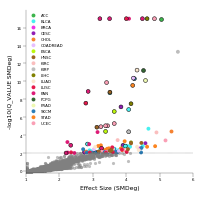

In [62]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])]
df_not_sigs = df_sm_degron_ttype[~(df_sm_degron_ttype["significant_SM"])]
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        #if lws[i] > 0:
            #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

# create the coordinates for the errorbars

ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)
# Adjust axis
ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_all_TCGA_tri.png', dpi=900,bbox_inches="tight")
None

### pdf not (not significant)

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


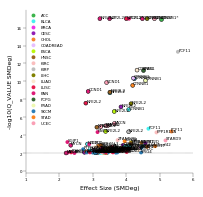

In [63]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])]
df_not_sigs = df_sm_degron_ttype[~(df_sm_degron_ttype["significant_SM"])].sample(frac=0.0)
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        #if lws[i] > 0:
            #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)
# Adjust axis
ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_all_TCGA_tri.pdf', dpi=900,bbox_inches="tight")
None

### Finally check enrichment in oncogenes

In [64]:
df_roles = pd.read_csv(role_data,sep="\t")
df_roles["Hugo_Symbol"] = df_roles["gene"]
df_roles["ROLE"] = df_roles["gene_MoA"]

In [65]:
df_sm_degron_ttype = df_sm_degron_ttype.merge(df_roles[["Hugo_Symbol","ROLE"]],how="left")
df_sm_degron_ttype["ROLE"].fillna("Unknown",inplace=True)

In [66]:
df_sm_degron_ttype[(df_sm_degron_ttype["ROLE"]!="aAct")&(df_sm_degron_ttype["significant_SM"])].sort_values("Q_VALUE_SIM_TCGA")[["Hugo_Symbol","DEGRON","Q_VALUE_SIM_TCGA","PPI","Prob_DEGRON","Cancer_Type","Entry_Isoform","START","ROLE"]]

Hugo_Symbol               DEGRON  Q_VALUE_SIM_TCGA    PPI  Prob_DEGRON  \
3199      CTNNB1      DEG_SCF_TRCP1_1     3.540000e-262  971.0       0.9660   
3197      CTNNB1      DEG_SCF_TRCP1_1     3.170000e-101  971.0       0.9660   
3191      CTNNB1      DEG_SCF_TRCP1_1      3.070000e-96  971.0       0.9660   
3475      NFE2L2    DEG_Kelch_Keap1_2      1.160000e-70  996.0       0.7333   
3467      NFE2L2    DEG_Kelch_Keap1_1      1.080000e-45  996.0       0.9720   
3470      NFE2L2    DEG_Kelch_Keap1_2      1.900000e-43  996.0       0.7333   
3070       PCF11    DEG_APCC_KENBOX_2      4.580000e-21    0.0       0.7960   
3189      CTNNB1      DEG_SCF_TRCP1_1      9.400000e-17  971.0       0.9660   
3068       PCF11    DEG_APCC_KENBOX_2      4.960000e-14    0.0       0.7960   
2216       EPAS1       DEG_ODPH_VHL_1      4.990000e-12  994.0       0.8728   
3195      CTNNB1      DEG_SCF_TRCP1_1      5.480000e-12  971.0       0.9660   
3194      CTNNB1      DEG_SCF_TRCP1_1      4.300000e-11  971.0       0.9660   
3198      CTNNB1      DEG_SCF_TRCP1_1      4.940000e-11  971.0       0.9660   
3190      CTNNB1      DEG_SCF_TRCP1_1      7.720000e-11  971.0       0.9660   
620        CCND1           SCF_FBXO31      1.340000e-10  580.0       0.9235   
3193      CTNNB1      DEG_SCF_TRCP1_1      2.800000e-10  971.0       0.9660   
621        CCND1           SCF_FBXO31      1.310000e-09  580.0       0.9235   
3471      NFE2L2    DEG_Kelch_Keap1_2      1.580000e-09  996.0       0.7333   
3473      NFE2L2    DEG_Kelch_Keap1_2      1.880000e-09  996.0       0.7333   
3462      NFE2L2    DEG_Kelch_Keap1_1      2.670000e-08  996.0       0.9720   
3460      NFE2L2    DEG_Kelch_Keap1_1      3.100000e-08  996.0       0.9720   
3461      NFE2L2    DEG_Kelch_Keap1_1      7.010000e-08  996.0       0.9720   
3196      CTNNB1      DEG_SCF_TRCP1_1      1.380000e-07  971.0       0.9660   
3459      NFE2L2    DEG_Kelch_Keap1_1      2.290000e-07  996.0       0.9720   
414         MYCN       DEG_SCF_FBW7_2      5.050000e-06  460.0       0.5472   
3474      NFE2L2    DEG_Kelch_Keap1_2      8.870000e-06  996.0       0.7333   
412         MYCN       DEG_SCF_FBW7_1      8.870000e-06  460.0       0.9628   
3466      NFE2L2    DEG_Kelch_Keap1_1      1.140000e-05  996.0       0.9720   
3463      NFE2L2    DEG_Kelch_Keap1_1      1.290000e-05  996.0       0.9720   
3069       PCF11    DEG_APCC_KENBOX_2      1.900000e-05    0.0       0.7960   
...          ...                  ...               ...    ...          ...   
3469      NFE2L2    DEG_Kelch_Keap1_2      8.240000e-03  996.0       0.7333   
1660       MAGI2              CBL_MET      8.320000e-03    0.0       0.4473   
2306       FGF23      DEG_APCC_DBOX_1      8.320000e-03    0.0       0.9118   
1214     CACNA1E      DEG_APCC_DBOX_1      8.320000e-03    0.0       0.6725   
2957       PODXL       DEG_SCF_FBW7_1      8.320000e-03    0.0       0.8764   
377        RAB36      DEG_APCC_DBOX_1      8.380000e-03    0.0       0.5375   
4327        PRG4       DEG_SCF_FBW7_1      8.470000e-03    0.0       0.8268   
1923        DLG5                 ITCH      8.470000e-03    0.0       0.7991   
2452       MUC5B       DEG_SPOP_SBC_1      8.470000e-03    0.0       0.9239   
4107     ARIH2OS           DEG_COP1_1      8.470000e-03    0.0       0.9381   
791        MYOM1       DEG_SCF_FBW7_2      8.470000e-03    0.0       0.5397   
1623       RBBP6       DEG_SCF_FBW7_1      8.580000e-03  905.0       0.6445   
4461        PKP4       DEG_SPOP_SBC_1      8.580000e-03    0.0       0.6860   
1974      ATXN2L      DEG_APCC_DBOX_1      8.580000e-03    0.0       0.8041   
938         PAX8       DEG_SPOP_SBC_1      8.580000e-03    0.0       0.7141   
3305        IRX5    DEG_APCC_KENBOX_2      8.690000e-03    0.0       0.6111   
330       ABLIM3       DEG_SPOP_SBC_1      8.750000e-03    0.0       0.5418   
4817        EXO1           DEG_COP1_1      8.810000e-03    0.0       0.5064   
4347        PRG4       DEG_SPOP_SBC_1      8.940000e-03

### Perform an statistical test to measure enrichment of oncogenes

In [67]:
from scipy import stats

### unique

In [68]:
x=df_sm_degron_ttype
sa = set(x[(x["significant_SM"])&(x["ROLE"]=="Act")]["Hugo_Symbol"].values)
a=len(sa)
sb = set(x[(x["significant_SM"])&(x["ROLE"]!="Act")]["Hugo_Symbol"].values)
b=len(sb)
sc = set(x[(~x["significant_SM"])&(x["ROLE"]=="Act")]["Hugo_Symbol"].values)
c = len(sc.difference(sa))
sd = set(x[(~x["significant_SM"])&(x["ROLE"]!="Act")]["Hugo_Symbol"].values)
d = len(sd.difference(sb))
print (stats.fisher_exact([[a,b],[c,d]]),a,b,c,d)

(1.7849607182940517, 0.19168684150221818) 7 90 99 2272


### non-unique

In [69]:
a = len(df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])&(df_sm_degron_ttype["ROLE"]=="Act")]["Hugo_Symbol"].values)
b = len(df_sm_degron_ttype[(df_sm_degron_ttype["significant_SM"])&(df_sm_degron_ttype["ROLE"]!="Act")]["Hugo_Symbol"].values)
c = len(df_sm_degron_ttype[(~df_sm_degron_ttype["significant_SM"])&(df_sm_degron_ttype["ROLE"]=="Act")]["Hugo_Symbol"].values)
d = len(df_sm_degron_ttype[(~df_sm_degron_ttype["significant_SM"])&(df_sm_degron_ttype["ROLE"]!="Act")]["Hugo_Symbol"].values)
stats.fisher_exact([[a,b],[c,d]])

(8.565479228335205, 5.24036241983911e-19)

### MYCN

In [70]:
df_sm_degron_ttype[df_sm_degron_ttype["Hugo_Symbol"]=="MYCN"][["Cancer_Type","Q_VALUE_SIM_TCGA","DEGRON"]]

Cancer_Type  Q_VALUE_SIM_TCGA          DEGRON
412        UCEC          0.000009  DEG_SCF_FBW7_1
413         PAN          0.009810  DEG_SCF_FBW7_1
414        UCEC          0.000005  DEG_SCF_FBW7_2
415        SKCM          0.013300  DEG_SCF_FBW7_2
416         PAN          0.001340  DEG_SCF_FBW7_2

### CCND1

In [71]:
df_sm_degron_ttype[df_sm_degron_ttype["Hugo_Symbol"]=="CCND1"]

Entry_Isoform      DEGRON  START_FLANKING  END_FLANKING  START  END  \
620      P24385-1  SCF_FBXO31             276           295    287  295   
621      P24385-1  SCF_FBXO31             276           295    287  295   

     Prob_DEGRON                      GENE_ID HUGO_SYMBOL  TOTAL_MUTS_GENE  \
620       0.9235  P24385-1:SCF_FBXO31:276:295       CCND1               17   
621       0.9235  P24385-1:SCF_FBXO31:276:295       CCND1               42   

     ...  log2(ODD_RATIO)  effect_size_sm  log_pvalue_sm log_qvalue_sm  \
620  ...         6.229777            3.41      11.343902      9.872895   
621  ...         4.458997            2.86      11.428291      8.882729   

     significant_SM    color   lw     ed   text  ROLE  
620            True  #fa9fb5  0.5  black  CCND1   Act  
621            True  #dd1c77  0.5  black  CCND1   Act  

[2 rows x 71 columns]

### EPAS1

In [72]:
df_sm_degron_ttype[df_sm_degron_ttype["Hugo_Symbol"]=="EPAS1"][["Cancer_Type","Q_VALUE_SIM_TCGA"]]

Cancer_Type  Q_VALUE_SIM_TCGA
2216        PCPG      4.990000e-12
2217         PAN      2.160000e-02
2218         PAN      9.750000e-01
2219         PAN      9.750000e-01

### Tri-penta examples

In [16]:
x=df_sm_degron_ttype[df_sm_degron_ttype["Cancer_Type"]=="PAN"]

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


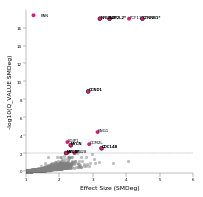

In [17]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = x[(x["significant_SM"])]
df_not_sigs = x[~(x["significant_SM"])]
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        if lws[i] > 0:
            ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

# create the coordinates for the errorbars

ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)
# Adjust axis
ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_PAN_tri.png', dpi=900,bbox_inches="tight")
None

In [13]:
x=df_sm_degron_ttype[df_sm_degron_ttype["Cancer_Type"]=="SKCM"]

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


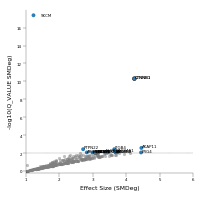

In [15]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = x[(x["significant_SM"])]
df_not_sigs = x[~(x["significant_SM"])]
limit = 16
df_sigs["log_qvalue_sm"]=df_sigs.apply(lambda row: limit +1 if row["log_qvalue_sm"]>=limit else row["log_qvalue_sm"],axis=1 )
df_sigs["text"]=df_sigs.apply(lambda row: row["text"]+"*" if row["log_qvalue_sm"]>=limit else row["text"],axis=1 )
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_sm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_sm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        if lws[i] > 0:
            ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["text"].values[i],fontsize=4,fontweight="normal")
        pass

# create the coordinates for the errorbars

ax.scatter(x=df_not_sigs["effect_size_sm"].values,y=df_not_sigs["log_qvalue_sm"].values,color="grey",s=10,alpha=0.5,linewidths=0)
#Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)
# Adjust axis
ax.set_ylabel("-log10(Q_VALUE SMDeg)",fontsize=6)
ax.set_xlabel("Effect Size (SMDeg)",fontsize=6)
ylim = (-0.2,limit+2)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]-1,2)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.01),xmin=0,xmax=np.nanmax(df_sigs["effect_size_sm"].values),color="black",ls="--",lw=0.2)
# x-axis
xlim = (1,6)
ax.set_xlim(xlim)
ax.set_xticks([x for x in range(xlim[0],xlim[1]+1,1)])

plt.savefig(path_output_plots+'/SM_SKCM_tri.png', dpi=900,bbox_inches="tight")
None